In [7]:
%%capture
!pip install -q imantics
!pip install -U pylabel
!pip install -U ultralytics

In [8]:
import os
import random
import json
import numpy as np
import random
from itertools import chain
import shutil
from tqdm.notebook import tqdm
import yaml

import imantics
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import albumentations as A

In [9]:
from pylabel import importer

#Specify path to the coco.json file
path_to_annotations = r"/content/annotations/instances_default.json"
#Specify the path to the images (if they are in a different folder than the annotations)
path_to_images = r"/content/images"

#Import the dataset into the pylable schema
dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images, name="BCCD_coco")
dataset.df.head(5)

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_iscrowd,ann_keypoints,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,/content/images,0.jpg,,1,1920,1080,,,1603.3,579.9,...,0,,,,,1,person,,,1
1,/content/images,0.jpg,,1,1920,1080,,,1548.3,375.7,...,0,,,,,1,person,,,1
2,/content/images,0.jpg,,1,1920,1080,,,1560.2,539.1,...,0,,,,,1,person,,,1
3,/content/images,0.jpg,,1,1920,1080,,,1361.5,321.6,...,0,,,,,1,person,,,1
4,/content/images,0.jpg,,1,1920,1080,,,147.0,881.9,...,0,,,,,1,person,,,1


In [10]:
dataset.df["image_path"]=dataset.df["img_folder"]+"/"+dataset.df["img_filename"]
df=dataset.df[["image_path","img_filename","img_width","img_height","ann_segmentation"]]

In [11]:
df.head()

,image_path,img_filename,img_width,img_height,ann_segmentation
id,,,,,
0,/content/images/0.jpg,0.jpg,1920,1080,"[[1630.5, 686.9, 1632.0, 683.6, 1633.4, 679.7,..."
1,/content/images/0.jpg,0.jpg,1920,1080,"[[1551.9, 433.7, 1551.5, 436.3, 1551.6, 439.1,..."
2,/content/images/0.jpg,0.jpg,1920,1080,"[[1608.5, 611.0, 1609.9, 606.7, 1611.5, 603.8,..."
3,/content/images/0.jpg,0.jpg,1920,1080,"[[1395.4, 382.3, 1397.0, 378.8, 1398.8, 374.9,..."
4,/content/images/0.jpg,0.jpg,1920,1080,"[[167.7, 1017.5, 166.0, 1012.0, 165.2, 1006.5,..."


In [12]:
def yolo_format(segmentation):
    result=[]
    divisors = [1920, 1080]
    for i,num in enumerate(segmentation[0]):
        divisor=divisors[i % len(divisors)]
        result.append(num / divisor)
    return [0]+result

In [13]:
df["segmentations"]=df["ann_segmentation"].apply(yolo_format)

<ipython-input-13-3da3f14d6425>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["segmentations"]=df["ann_segmentation"].apply(yolo_format)


In [14]:
df.head()

,image_path,img_filename,img_width,img_height,ann_segmentation,segmentations
id,,,,,,
0,/content/images/0.jpg,0.jpg,1920,1080,"[[1630.5, 686.9, 1632.0, 683.6, 1633.4, 679.7,...","[0, 0.84921875, 0.6360185185185185, 0.85, 0.63..."
1,/content/images/0.jpg,0.jpg,1920,1080,"[[1551.9, 433.7, 1551.5, 436.3, 1551.6, 439.1,...","[0, 0.8082812500000001, 0.4015740740740741, 0...."
2,/content/images/0.jpg,0.jpg,1920,1080,"[[1608.5, 611.0, 1609.9, 606.7, 1611.5, 603.8,...","[0, 0.8377604166666667, 0.5657407407407408, 0...."
3,/content/images/0.jpg,0.jpg,1920,1080,"[[1395.4, 382.3, 1397.0, 378.8, 1398.8, 374.9,...","[0, 0.7267708333333334, 0.3539814814814815, 0...."
4,/content/images/0.jpg,0.jpg,1920,1080,"[[167.7, 1017.5, 166.0, 1012.0, 165.2, 1006.5,...","[0, 0.08734375, 0.9421296296296297, 0.08645833..."


In [15]:
unique_images = df['img_filename'].unique()
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Add a new column 'split' to indicate the split
train_df['split'] = 'train'
test_df['split'] = 'test'

# Concatenate train and test sets back into one DataFrame
import pandas as pd
result_df = pd.concat([train_df, test_df], ignore_index=True)

In [16]:
result_df.head()

,image_path,img_filename,img_width,img_height,ann_segmentation,segmentations,split
0,/content/images/195.jpg,195.jpg,1920,1080,"[[876.0, 309.2, 877.5, 309.1, 879.2, 308.9, 88...","[0, 0.45625, 0.28629629629629627, 0.45703125, ...",train
1,/content/images/331.jpg,331.jpg,1920,1080,"[[1005.44, 538.82, 1005.64, 537.72, 1006.24, 5...","[0, 0.5236666666666667, 0.49890740740740747, 0...",train
2,/content/images/378.jpg,378.jpg,1920,1080,"[[866.53, 308.76, 864.63, 313.26, 861.73, 318....","[0, 0.45131770833333335, 0.28588888888888886, ...",train
3,/content/images/128.jpg,128.jpg,1920,1080,"[[806.38, 493.73, 810.5, 490.9, 813.8, 488.8, ...","[0, 0.4199895833333333, 0.4571574074074074, 0....",train
4,/content/images/257.jpg,257.jpg,1920,1080,"[[1755.76, 274.12, 1754.56, 272.44, 1753.6, 27...","[0, 0.9144583333333334, 0.2538148148148148, 0....",train


In [17]:
# Creating Directories

parent_dirpath = "/content/yolov8"

os.mkdir(parent_dirpath)

os.mkdir(os.path.join(parent_dirpath, "train"))
os.mkdir(os.path.join(parent_dirpath, "train", "images"))
os.mkdir(os.path.join(parent_dirpath, "train", "labels"))

os.mkdir(os.path.join(parent_dirpath, "test"))
os.mkdir(os.path.join(parent_dirpath, "test", "images"))
os.mkdir(os.path.join(parent_dirpath, "test", "labels"))

In [18]:
from shutil import copyfile

for i in tqdm(range(len(result_df))):
    row = result_df.loc[i]
    if row.split == 'train':
        copyfile(row.image_path, f'/content/yolov8/train/images/{row.img_filename}')
    else:
        copyfile(row.image_path, f'/content/yolov8/test/images/{row.img_filename}')

  0%|          | 0/7686 [00:00<?, ?it/s]

In [19]:
def get_bbox(row):
    bbox = str(row.segmentations).replace('[','').replace(']','').replace(',','')
    return bbox

In [20]:
for i in tqdm(range(len(result_df))):
    row = result_df.loc[i]

    if row.split == 'train':
        file_name = f'/content/yolov8/train/labels/{row.img_filename.split(".")[0]}.txt'
    else:
        file_name = f'/content/yolov8/test/labels/{row.img_filename.split(".")[0]}.txt'

    #get the bounding boxes in yolo format
    bboxes = get_bbox(row)

    #write the bounding boxes in each corresponding file
    with open(file_name, 'a') as f:
        f.write(bboxes)
        f.write('\n')

  0%|          | 0/7686 [00:00<?, ?it/s]

In [21]:
%cd ../../../
%cd content/

/
/content


In [22]:
%%writefile dataset.yaml
path: ../../../../../content/yolov8
train: train/images
val: test/images
test: test/images

# Classes
names:
    0: player

Writing dataset.yaml


In [23]:
from ultralytics import YOLO

model = YOLO("yolov8x-seg.pt")
model.train(
    # Project
    project="football",
    name="YOLOV8-segmentation",

    # Random Seed parameters
    deterministic=True,
    seed=43,

    # Data & model parameters
    data="/content/dataset.yaml",
    save=True,
    save_period=5,
    pretrained=True,
    imgsz=(1920,1080),

    # Training parameters
    epochs=2,
    batch=1,
    workers=4,
    val=True,
    device=0,

    # Optimization parameters
    lr0=0.018,
    patience=3,
    optimizer="Adam",
    momentum=0.947,
    weight_decay=0.0005,
    close_mosaic=3,
)

100%|██████████| 137M/137M [00:01<00:00, 74.9MB/s]


Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=/content/dataset.yaml, epochs=2, time=None, patience=3, batch=1, imgsz=(1920, 1080), save=True, save_period=5, cache=False, device=0, workers=4, project=football, name=YOLOV8-segmentation, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=3, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

100%|██████████| 755k/755k [00:00<00:00, 20.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 102MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1920'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /content/yolov8/train/labels... 512 images, 0 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:01<00:00, 438.55it/s]

train: WARNING ⚠️ /content/yolov8/train/images/209.jpg: 3 duplicate labels removed
train: New cache created: /content/yolov8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolov8/test/labels... 486 images, 0 backgrounds, 0 corrupt: 100%|██████████| 486/486 [00:01<00:00, 388.56it/s]

val: WARNING ⚠️ /content/yolov8/test/images/209.jpg: 1 duplicate labels removed
val: New cache created: /content/yolov8/test/labels.cache


Plotting labels to football/YOLOV8-segmentation/labels.jpg... 
optimizer: Adam(lr=0.018, momentum=0.947) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1920 train, 1920 val
Using 2 dataloader workers
Logging results to football/YOLOV8-segmentation
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/2      12.6G      1.045      1.532       1.14      1.042         25       1920: 100%|██████████| 512/512 [07:51<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:37<00:00,  2.50it/s]


                   all        486       1537      0.204      0.787      0.194      0.143      0.203      0.782      0.192      0.129

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/2      12.6G     0.8621      1.339     0.8847     0.9784         16       1920: 100%|██████████| 512/512 [07:43<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:36<00:00,  2.52it/s]

                   all        486       1537      0.206      0.882      0.207       0.17      0.205      0.878      0.205      0.155



2 epochs completed in 0.325 hours.
Optimizer stripped from football/YOLOV8-segmentation/weights/last.pt, 144.2MB
Optimizer stripped from football/YOLOV8-segmentation/weights/best.pt, 144.2MB

Validating football/YOLOV8-segmentation/weights/best.pt...
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients, 343.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [01:33<00:00,  2.60it/s]


                   all        486       1537      0.206      0.882      0.207       0.17      0.205      0.878      0.205      0.155
Speed: 1.9ms preprocess, 165.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to football/YOLOV8-segmentation


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e31df70e080>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

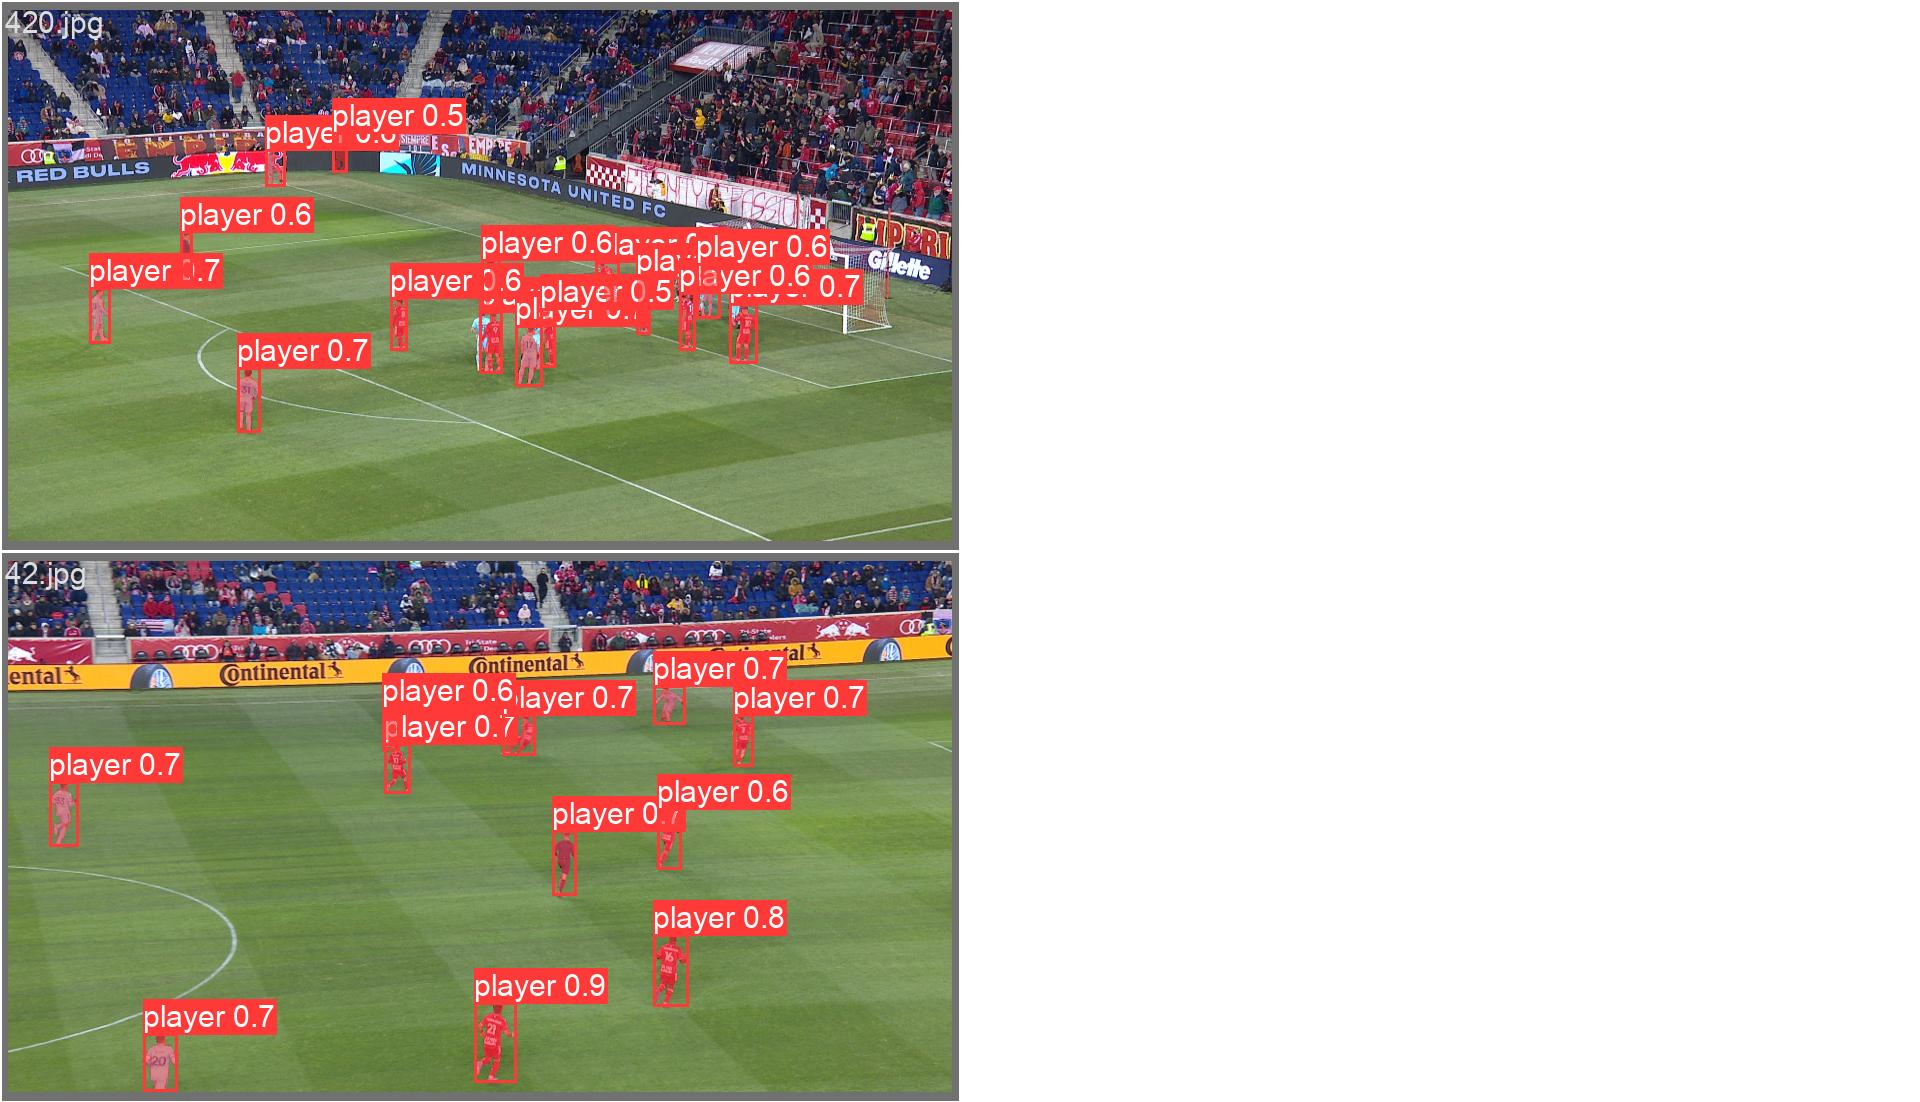

In [25]:
from PIL import Image
Image.open("/content/football/YOLOV8-segmentation/val_batch2_pred.jpg")

In [27]:
saved_model = YOLO("/content/football/YOLOV8-segmentation/weights/best.pt")


image 1/1 /content/football_p1.jpg: 1088x1920 22 players, 599.6ms
Speed: 9.3ms preprocess, 599.6ms inference, 44.7ms postprocess per image at shape (1, 3, 1088, 1920)


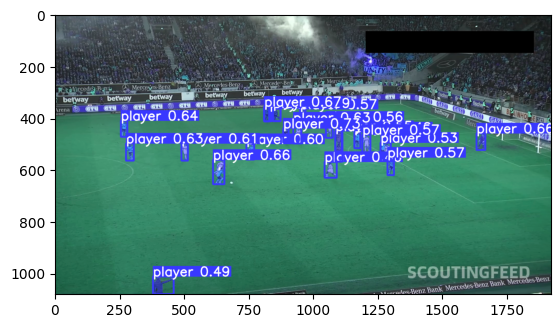

In [28]:
history = saved_model.predict("/content/football_p1.jpg", conf=0.3)[0]
image = history.plot()
plt.imshow(image)
plt.show()